In [31]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

Reading data into DataFrame


In [32]:
train_df = pd.read_csv("./project_data/train_dataset.csv")
test_df = pd.read_csv("./project_data/test_dataset.csv")
train_df.drop("title_embedding", axis=1, inplace=True)
test_df.drop("title_embedding", axis=1, inplace=True)
train_df.drop("id", axis=1, inplace=True)
test_df.drop("id", axis=1, inplace=True)

In [33]:
test_label = [i for i in train_df['imdb_score_binned'][0:752]]
test_df['imdb_score_binned'] = test_label
dataset = pd.concat([train_df, test_df], axis = 0)
label = dataset['imdb_score_binned']
dataset.reset_index(drop=True, inplace=True)

One hot encdoing "genres" column, label encoding "content_rating","title_year", "country", "language" columns

In [34]:
one_hot_encoding = dataset['genres'].str.get_dummies(sep='|')

dataset = pd.concat([dataset, one_hot_encoding], axis=1)

embedded_data = dataset
label_encoder = LabelEncoder()

# Encoding each categorical column
for column in ['content_rating','title_year', 'country', 'language']:
    embedded_data[column] = label_encoder.fit_transform(embedded_data[column])

Droping unecessary columns

In [35]:
drop_cols = ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name','imdb_score_binned', 'genres', 'movie_title', 'plot_keywords']

embedded_data.drop(columns=drop_cols, inplace=True)
embedded_data

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,186,73,28,847,2000,422783777,644348,6458,0,656,...,0,0,1,0,0,0,0,0,0,0
1,252,97,0,233,654,20433940,78883,1876,8,662,...,1,0,0,0,0,0,0,0,0,0
2,232,117,234,221,12000,371897,36494,13607,2,118,...,0,0,0,0,0,0,0,0,0,0
3,297,109,0,145,957,13782838,258078,1757,0,911,...,1,0,0,1,0,1,0,0,0,0
4,297,171,0,857,16000,313837577,1238746,22342,2,5060,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3751,179,93,0,766,13000,17096053,134458,15716,2,640,...,0,0,0,0,0,0,0,0,0,0
3752,393,105,335,911,3000,37516013,128629,8281,0,348,...,1,0,0,0,0,0,0,0,0,0
3753,55,117,133,249,687,20966644,29610,1665,0,94,...,0,0,0,0,1,0,0,0,0,0
3754,85,72,0,384,3000,47887943,11634,4480,0,58,...,0,0,1,0,0,0,0,0,0,0


Normalizing dataset using Standard Scaler() 

Note: Comment this block of code to assess the impact of normalization on SVC and LR models.

In [36]:
columns_to_normalize = ['gross', 'duration', 'num_critic_for_reviews', 'num_user_for_reviews', 'movie_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes','actor_3_facebook_likes'
             ,'actor_2_facebook_likes', 'actor_1_facebook_likes', 'director_facebook_likes']

scaler = StandardScaler()

# Fit the scaler to the dataset (excluding the 'id' column) and transform the data
embedded_data[columns_to_normalize] = scaler.fit_transform(embedded_data[columns_to_normalize])

# Convert the normalized data array back to a DataFrame
embedded_data = pd.DataFrame(embedded_data)

Split the data to target column y and feature matrix X

In [37]:
embedded_train_df = embedded_data.iloc[:3004]
embedded_test_df = embedded_data.iloc[-752:]
y = label[:3004]
X = embedded_train_df
X

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0.150861,-1.645402,-0.254041,0.039979,-0.370641,5.264953,3.542550,-0.265126,0,0.776211,...,0,0,1,0,0,0,0,0,0,0
1,0.685553,-0.585504,-0.263168,-0.284203,-0.457383,-0.457681,-0.177244,-0.504774,8,0.790804,...,1,0,0,0,0,0,0,0,0,0
2,0.523525,0.297743,-0.186891,-0.290539,0.273802,-0.743024,-0.456091,0.108783,2,-0.532242,...,0,0,0,0,0,0,0,0,0,0
3,1.050116,-0.055556,-0.263168,-0.330665,-0.437856,-0.552280,1.001553,-0.510998,0,1.396389,...,1,0,0,1,0,1,0,0,0,0
4,1.050116,2.682513,-0.263168,0.045259,0.531579,3.715408,7.452673,0.565644,2,11.487041,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,-0.051673,0.827692,-0.249477,-0.381352,-0.493279,0.587972,0.172491,-0.586261,7,-0.325516,...,0,0,0,0,1,0,0,0,0,0
3000,1.827849,0.562718,0.388773,-0.158543,1.176022,-0.365662,1.360406,1.343065,0,0.336007,...,0,0,0,0,0,0,1,0,0,0
3001,0.393903,0.341906,-0.108984,0.101225,0.660468,0.294852,0.734488,0.574797,0,0.224132,...,0,0,0,0,0,0,0,1,0,0
3002,-0.472946,-0.673829,-0.263168,-0.407223,-0.484901,-0.733229,-0.632021,-0.590812,0,-0.658709,...,0,0,0,0,1,0,0,0,0,0


Baseline 0R

In [38]:
from sklearn.model_selection import KFold


dummy_classifier = DummyClassifier(strategy="most_frequent")

k_fold = KFold(n_splits= 3, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(dummy_classifier, X, y, cv=k_fold, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.61477046 0.5974026  0.62437562]
Mean accuracy: 0.6121828936200194


Running grid search to choose the best hyperparameters for SVC

In [39]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf'))
])
param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=2, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation accuracy: {:.2f}".format(grid_search.best_score_))


Fitting 3 folds for each of 25 candidates, totalling 75 fits


[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.5s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.5s
[CV] END .........................svc__C=0.1, svc__gamma=0.1; total time=   0.6s
[CV] END .........................svc__C=0.1, svc__gamma=0.1; total time=   0.7s
[CV] END .........................svc__C=0.1, svc__gamma=0.1; total time=   0.7s
[CV] END ...........................svc__C=0.1, svc__gamma=1; total time=   0.9s
[CV] END ...........................svc__C=0.1, svc__gamma=1; total time=   0.9s
[CV] END .......................svc__C=0.1, svc__gamma=0.001; total time=   0.4s
[CV] END ........................svc__C=0.1, svc__gamma=0.01; total time=   0.5s
[CV] END ...........................svc__C=0.1, svc__gamma=1; total time=   1.0s
[CV] END .......................svc__C=0.1, svc__gamma=0.001; total time=   0.5s
[CV] END .......................svc__C=0.1, svc__gamma=0.001; total time=   0.5s
[CV] END ...................

SVC model training and predicting, output stored in 'predicted_labels_SVC.csv'

Mean CV accuracy: 0.7410084925054985
[[  0   0   5   0   0]
 [  0   0  48   0   0]
 [  0   0 353  24   0]
 [  0   0  63  83   6]
 [  0   0   3   6  10]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.75      0.94      0.83       377
           3       0.73      0.55      0.63       152
           4       0.62      0.53      0.57        19

    accuracy                           0.74       601
   macro avg       0.42      0.40      0.41       601
weighted avg       0.67      0.74      0.70       601

Accuracy: 0.74


/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


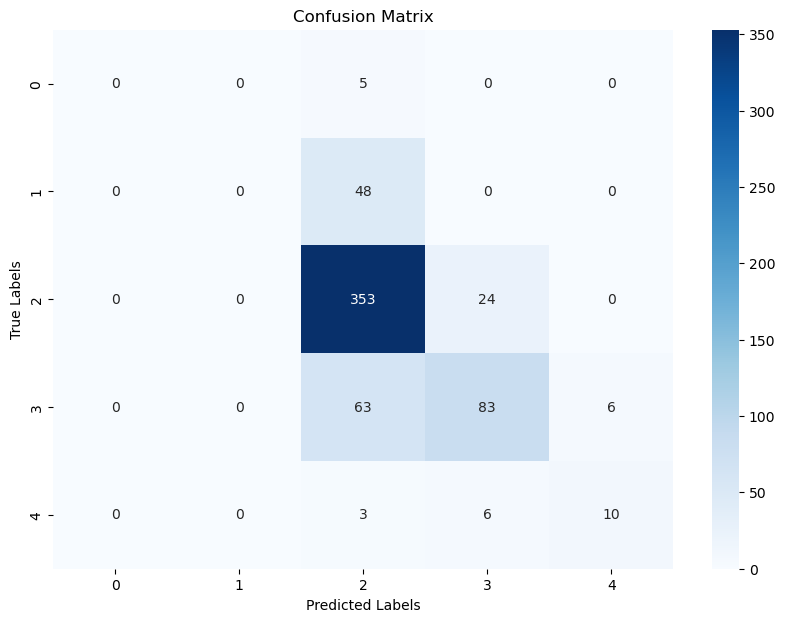

In [40]:

model = SVC(kernel='rbf', C=100, gamma=0.001, random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Mean CV accuracy:", cv_scores.mean())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Plotting confusion matrix
cm_svc = confusion_matrix(y_test, y_pred)
cm_svc
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

y_pred = model.predict(embedded_test_df)

# Stored the output
num_rows = len(embedded_test_df)
id_column = range(1, num_rows + 1)
predicted_df = pd.DataFrame({'id': id_column, 'imdb_score_binned': y_pred})
predicted_df.to_csv('predicted_labels_SVC.csv', index=False)


Logistic Regression model training and predicting, output stored in 'predicted_labels_LR.csv'

Cross-validation scores: [0.72954092 0.71128871 0.70929071]
Mean CV accuracy: 0.7167067795810311
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00        48
           2       0.74      0.95      0.83       377
           3       0.76      0.50      0.60       152
           4       0.75      0.63      0.69        19

    accuracy                           0.74       601
   macro avg       0.45      0.42      0.42       601
weighted avg       0.68      0.74      0.69       601



/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


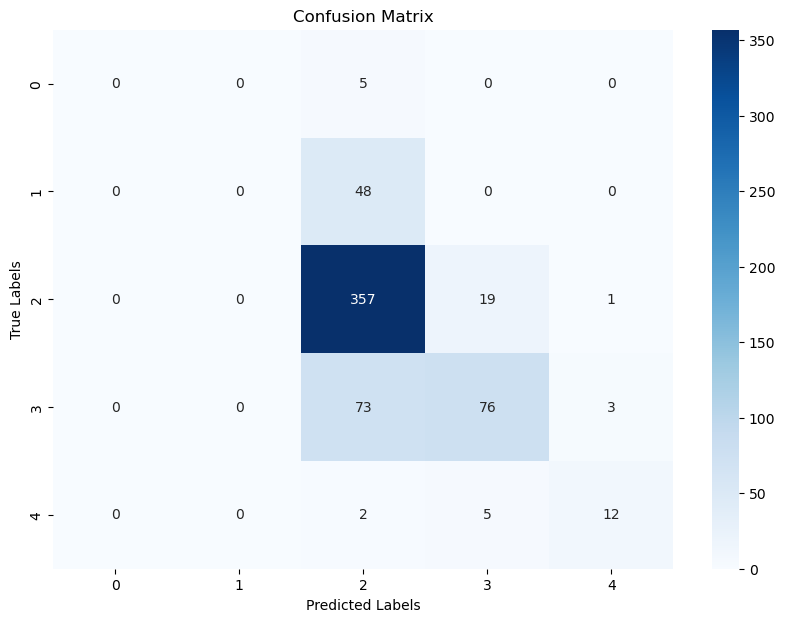

In [41]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd

model = LogisticRegression(solver='liblinear', random_state=42)

# Perform cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the full training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

cm_log_reg = confusion_matrix(y_test, y_pred)
cm_log_reg
print(classification_report(y_test, y_pred))

plt.figure(figsize=(10, 7))
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

y_pred = model.predict(embedded_test_df)

# Stored the output
num_rows = len(embedded_test_df)
id_column = range(1, num_rows + 1)
predicted_df = pd.DataFrame({'id': id_column, 'imdb_score_binned': y_pred})
predicted_df.to_csv('predicted_labels_LR.csv', index=False)


Running grid search for Random Forest classifier, training and testing, stored the output as 'predicted_labels_RF.csv'

Cross-validation scores: [0.74351297 0.72827173 0.73626374]
Mean CV accuracy: 0.7360161461957869
[[  0   0   6   0   0]
 [  0   0  73   0   0]
 [  0   0 516  37   1]
 [  0   0  94 137   4]
 [  0   0   1  17  16]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.00      0.00      0.00        73
           2       0.75      0.93      0.83       554
           3       0.72      0.58      0.64       235
           4       0.76      0.47      0.58        34

    accuracy                           0.74       902
   macro avg       0.45      0.40      0.41       902
weighted avg       0.67      0.74      0.70       902

Accuracy: 0.7417


/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/thinhtran/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


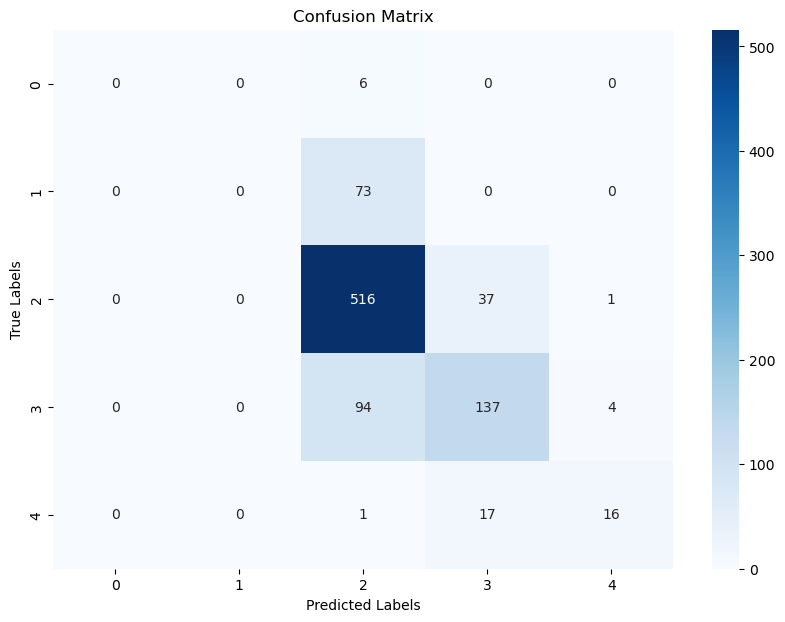

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42
)
# Perform cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())


model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Print the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Print out the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

cm_RF = confusion_matrix(y_test, y_pred)
cm_RF
plt.figure(figsize=(10, 7))
sns.heatmap(cm_RF, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#Predict on the test set
y_pred = model.predict(embedded_test_df)

# Stored the output
num_rows = len(embedded_test_df)
id_column = range(1, num_rows + 1)
predicted_df = pd.DataFrame({'id': id_column, 'imdb_score_binned': y_pred})
predicted_df.to_csv('predicted_labels_RF.csv', index=False)


Plotting feature importance for RF model

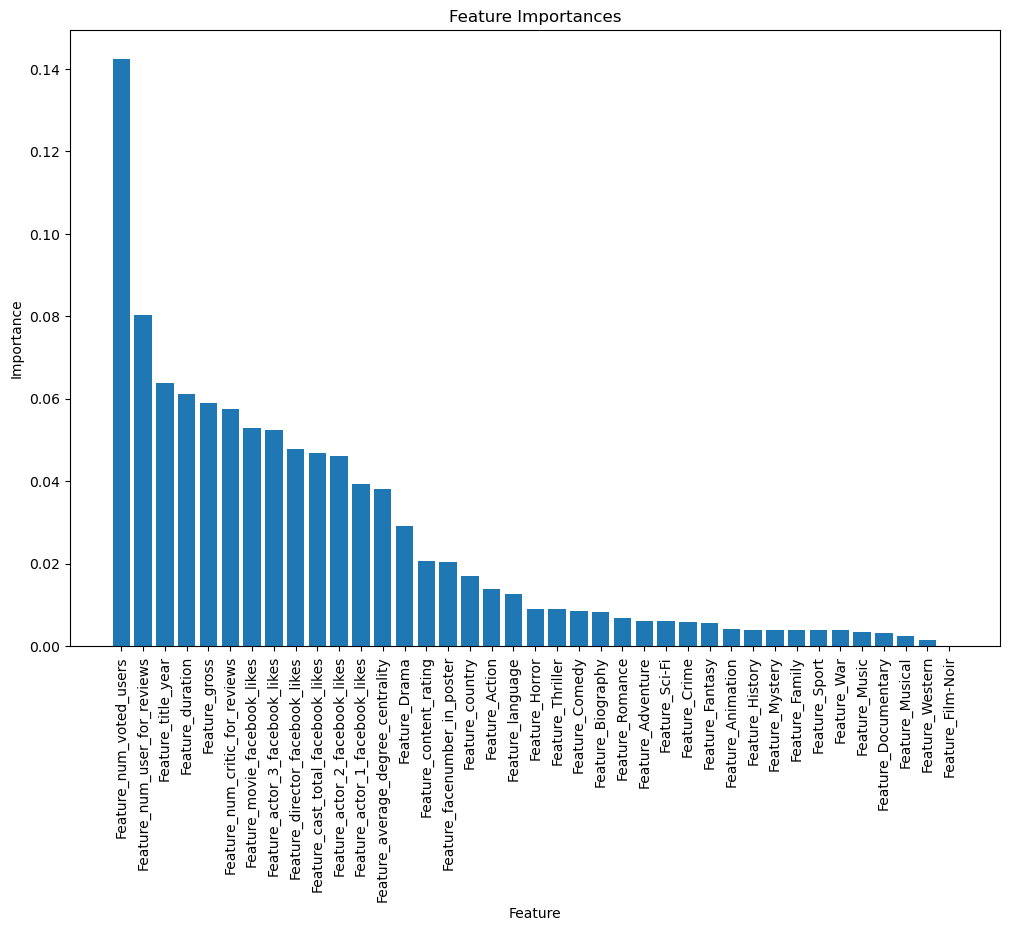

In [43]:

features = [f'Feature_{i}' for i in X.columns]
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42
)
model.fit(X, y)
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

Plotting confusion matrix of three models 

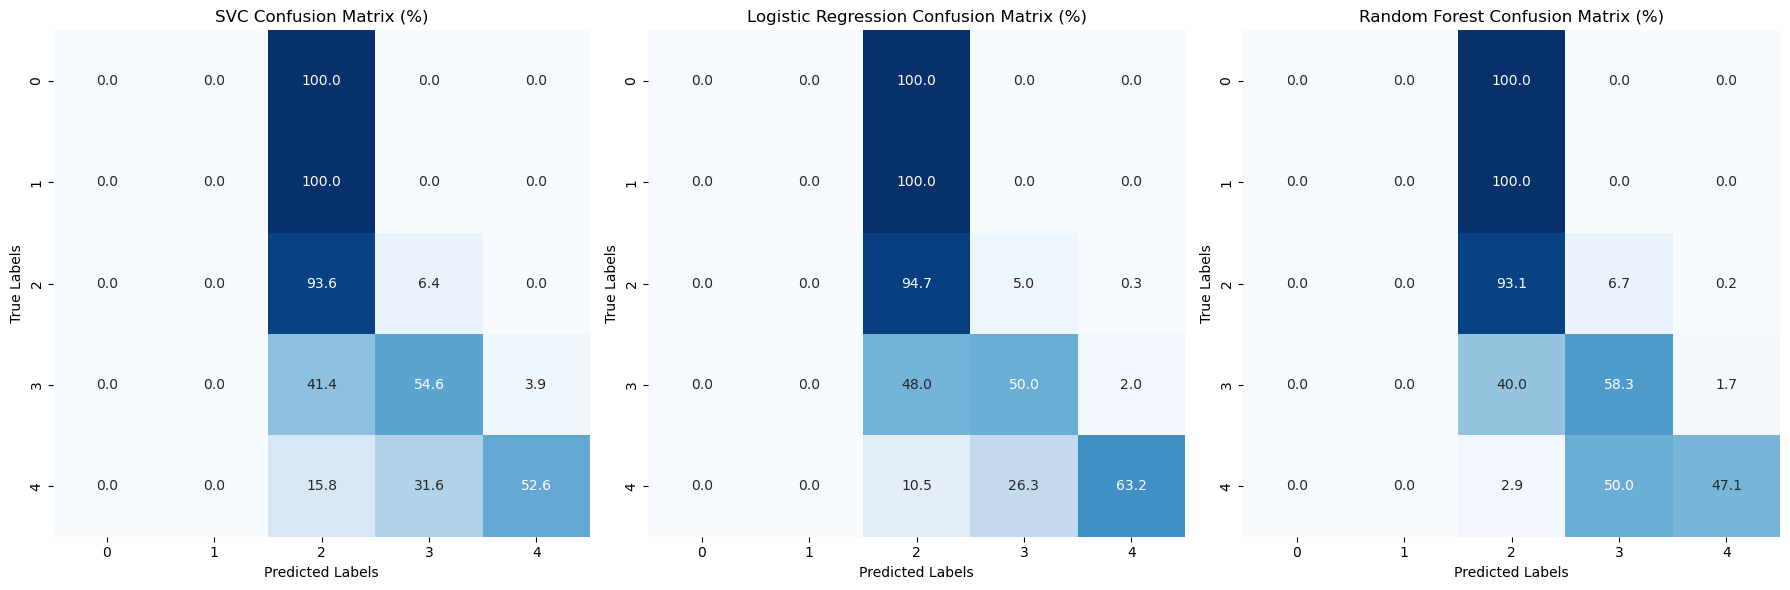

In [44]:
#Function to represent confusion matrix as percentage 
def to_percentage(cm):
    cm_perc = cm.astype(float)
    row_sums = cm.sum(axis=1).reshape(-1, 1) 
    cm_perc = (cm_perc / row_sums) * 100  
    cm_perc[np.isnan(cm_perc)] = 0
    return cm_perc

cm_svc_perc = to_percentage(cm_svc)
cm_log_reg_perc = to_percentage(cm_log_reg)
cm_rf_perc = to_percentage(cm_RF)


models = ['SVC', 'Logistic Regression', 'Random Forest']
cms = [cm_svc_perc, cm_log_reg_perc, cm_rf_perc]
labels = [0, 1, 2, 3, 4]
plt.figure(figsize=(18, 6))
for i, (model, cm) in enumerate(zip(models, cms), 1):
    plt.subplot(1, 3, i)
    sns.heatmap(cm, annot=True, fmt=".1f", cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.title(f'{model} Confusion Matrix (%)')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

Applying SMOTE to Random Forest classifier

[[  0   1   5   0   0]
 [  2  34  36   1   0]
 [  0  48 436  68   2]
 [  1   2  63 162   7]
 [  0   0   0  14  20]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.40      0.47      0.43        73
           2       0.81      0.79      0.80       554
           3       0.66      0.69      0.68       235
           4       0.69      0.59      0.63        34

    accuracy                           0.72       902
   macro avg       0.51      0.51      0.51       902
weighted avg       0.73      0.72      0.72       902

Accuracy: 0.72


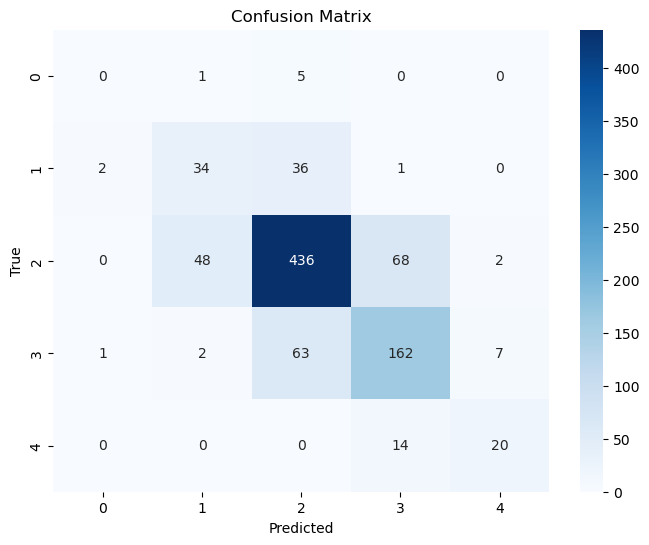

In [45]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

best_params = {
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 300
}

model = RandomForestClassifier(**best_params, random_state=42)

model.fit(X_resampled, y_resampled)

# Evaluate the model
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
labels = [0, 1, 2, 3, 4]

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


#Predict on test set
y_pred = model.predict(embedded_test_df)

# Stored the output
num_rows = len(embedded_test_df)
id_column = range(1, num_rows + 1)
predicted_df = pd.DataFrame({'id': id_column, 'imdb_score_binned': y_pred})
predicted_df.to_csv('predicted_labels_RF.csv', index=False)
